In [1]:
import ot
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
import time
from tqdm import tqdm

In [2]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [55]:
noise_param = 5e-4
image_indexes = np.random.randint(0, 10, 2)
category_indexes = np.random.randint(0, 10, 2)
# category_indexes = [0, 0]
image1 = Image(resolution, category_names[category_indexes[0]], 
               image_numbers[image_indexes[0]], full_path)
image2 = Image(resolution, category_names[category_indexes[1]], 
               image_numbers[image_indexes[1]], full_path)

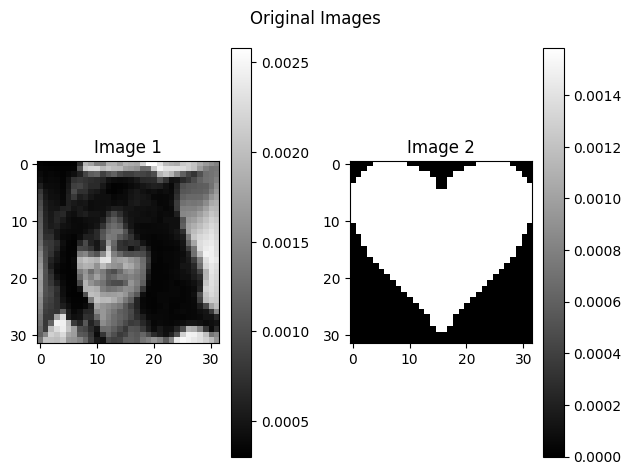

In [56]:
# Show the images:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Original Images')
axs[0].imshow(image1.image, cmap='gray')
axs[0].set_title('Image 1')
fig.colorbar(axs[0].imshow(image1.image, cmap='gray'), ax=axs[0])
axs[1].imshow(image2.image, cmap='gray')
axs[1].set_title('Image 2')
fig.colorbar(axs[1].imshow(image2.image, cmap='gray'), ax=axs[1])
plt.tight_layout()
plt.show()

In [57]:
num_exp = 10000
B_x_matrices = np.zeros((num_exp, resolution, resolution))
B_x_matrices_sub = np.zeros((num_exp, resolution, resolution))
B_x_matrices_sup = np.zeros((num_exp, resolution, resolution))
alpha_1s = np.zeros(num_exp)
alpha_2s = np.zeros(num_exp)

for i in tqdm(range(num_exp)):
    results = Image.process_images(image1, image2, noise_param)

    alpha_1 = (1 / image1.image_post_noised.sum()) - 1
    alpha_2 = (1 / image2.image_post_noised.sum()) - 1

    B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

    alpha_1s[i] = alpha_1
    alpha_2s[i] = alpha_2
    B_x_matrices[i, :, :] = B_x
    B_x_matrices_sub[i, :, :] = B_x - image1.image * alpha_1 + image2.image * alpha_2

B_x_mean = np.mean(B_x_matrices, axis=0)
B_x_std = np.std(B_x_matrices, axis=0)
B_x_mean_sub = np.mean(B_x_matrices_sub, axis=0)
B_x_std_sub = np.std(B_x_matrices_sub, axis=0)


100%|██████████| 10000/10000 [00:01<00:00, 8569.11it/s]


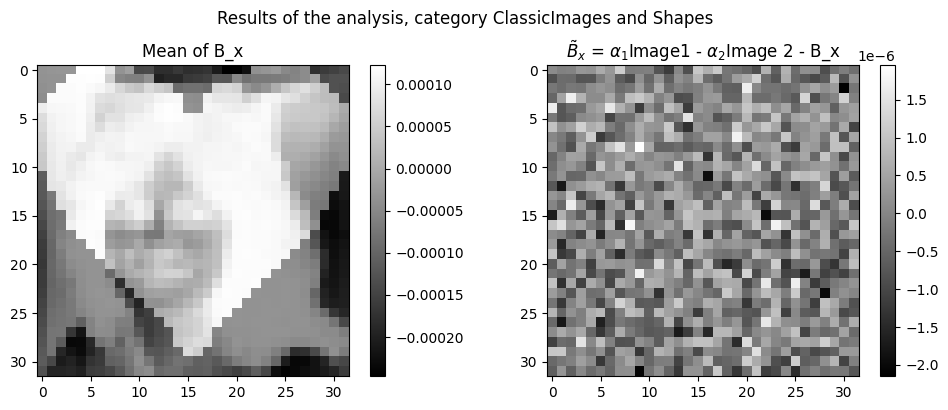

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(f'Results of the analysis, category {category_names[category_indexes[0]]} and {category_names[category_indexes[1]]}')
axs[0].imshow(B_x_mean, cmap='gray')
axs[0].set_title('Mean of B_x')
fig.colorbar(axs[0].imshow(B_x_mean, cmap='gray'), ax=axs[0])
axs[1].imshow(B_x_mean_sub, cmap='gray')
axs[1].set_title(r'$\tilde{B}_x$ = $\alpha_1$Image1 - $\alpha_2$Image 2 - B_x')
fig.colorbar(axs[1].imshow(B_x_mean_sub, cmap='gray'), ax=axs[1])
plt.tight_layout()
plt.show()

In [59]:
len(B_x_mean_sub.flatten())

1024

Original std is 0.0005
Mean: -2.1441063716026964e-08, Std: 6.721028310693019e-07
D'Agostino and Pearson's Test: Stat=0.3106517244946332, P-value=0.8561361495740426


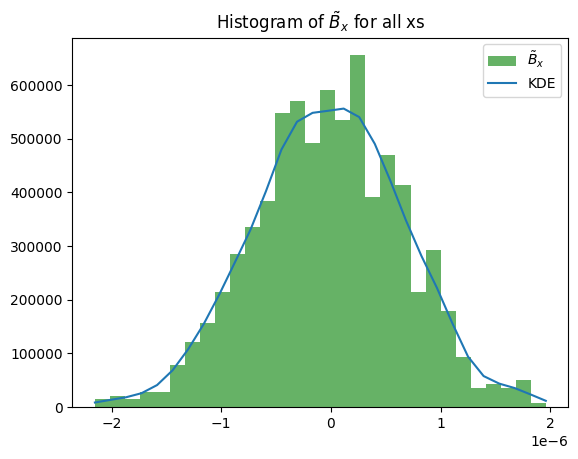

In [60]:
print(f'Original std is {noise_param}')
plt.hist(B_x_mean_sub.flatten(), bins=30, density=True, alpha=0.6, color='g', label=r'$\tilde{B}_x$')
print(f"Mean: {np.mean(B_x_mean_sub.flatten())}, Std: {np.std(B_x_mean_sub.flatten())}")
stat, p_value = normaltest(B_x_mean_sub.flatten())
print(f"D'Agostino and Pearson's Test: Stat={stat}, P-value={p_value}")
kde = gaussian_kde(B_x_mean_sub.flatten(), bw_method='silverman')
x = np.linspace(B_x_mean_sub.min(), B_x_mean_sub.max(), 30)
kde_pdf = kde(x)
plt.plot(x, kde_pdf, label='KDE')
plt.title(r'Histogram of $\tilde{B}_x$ for all xs')
plt.legend()
plt.show()

In [61]:
location = np.random.randint(0, resolution, 2)
pixel_values = B_x_matrices_sub[:, location[0], location[1]]

In [62]:
mean_value = np.mean(pixel_values)
std_dev = np.std(pixel_values)
min_value = np.min(pixel_values)
max_value = np.max(pixel_values)

print(f"Mean: {mean_value}, Standard Deviation: {std_dev}, Min: {min_value}, Max: {max_value}")

Mean: 1.7520005367184476e-06, Standard Deviation: 6.81155484340245e-05, Min: -0.0002344412981041566, Max: 0.0003223978250849538


Mean: 1.7520005367184476e-06, Standard Deviation: 6.81155484340245e-05


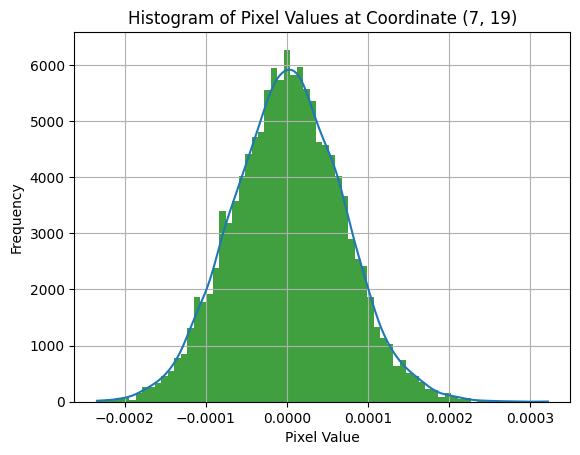

In [63]:
plt.hist(pixel_values, bins=70, alpha=0.75, color='g', density=True)
print(f"Mean: {mean_value}, Standard Deviation: {std_dev}")
plt.title(f'Histogram of Pixel Values at Coordinate ({location[0]}, {location[1]})')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
kde = gaussian_kde(pixel_values, bw_method='silverman')
x = np.linspace(pixel_values.min(), pixel_values.max(), 1000)
kde_pdf = kde(x)
plt.plot(x, kde_pdf, label='KDE')
plt.show()

Shapiro-Wilk Test: Stat=0.9995986819267273, P-value=0.03193432465195656
D'Agostino and Pearson's Test: Stat=7.184571876482648, P-value=0.02753531439715094


c:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


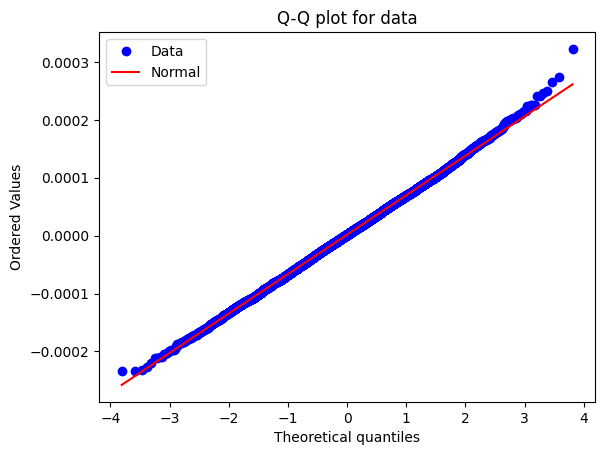

In [64]:
from scipy.stats import shapiro, normaltest

# Shapiro-Wilk Test
stat, p_value = shapiro(pixel_values)
print(f"Shapiro-Wilk Test: Stat={stat}, P-value={p_value}")

# D'Agostino and Pearson's Test
stat, p_value = normaltest(pixel_values)
print(f"D'Agostino and Pearson's Test: Stat={stat}, P-value={p_value}")

# Draw a Q-Q plot
probplot(pixel_values, dist="norm", plot=plt)
plt.title('Q-Q plot for data')
plt.legend(['Data', 'Normal'])
plt.show()

## Testing different Noise values

In [69]:
num_exp = 4000
df = pd.DataFrame(columns=['Noise', 'Mean', 'Std Dev', 'Shapiro-Wilk', 'DAP'])

image_indexes = np.random.randint(0, 10, 2)
category_indexes = np.random.randint(0, 10, 2)
image1 = Image(resolution, category_names[category_indexes[0]], image_numbers[image_indexes[0]], full_path)
image2 = Image(resolution, category_names[category_indexes[1]], image_numbers[image_indexes[1]], full_path)

for noise_param in tqdm(noise_values):
    B_x_matrices = np.zeros((num_exp, resolution, resolution))
    B_x_matrices_sub = np.zeros((num_exp, resolution, resolution))
    B_x_matrices_sup = np.zeros((num_exp, resolution, resolution))
    alpha_1s = np.zeros(num_exp)
    alpha_2s = np.zeros(num_exp)

    for i in range(num_exp):
        results = Image.process_images(image1, image2, noise_param)

        alpha_1 = (1 / image1.image_post_noised.sum()) - 1
        alpha_2 = (1 / image2.image_post_noised.sum()) - 1

        B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2

        alpha_1s[i] = alpha_1
        alpha_2s[i] = alpha_2
        B_x_matrices[i, :, :] = B_x
        B_x_matrices_sub[i, :, :] = B_x - image1.image * alpha_1 + image2.image * alpha_2

    for i in range(resolution):
        for j in range(resolution):
            pixel_values = B_x_matrices_sub[:, i, j]
            mean_value = np.mean(pixel_values)
            std_dev = np.std(pixel_values)
            shapiro_p_value = shapiro(pixel_values)[1]
            dap_p_value = normaltest(pixel_values)[1]

            df = df._append({'Noise': noise_param, 'Mean': mean_value, 'Std Dev': std_dev, 
                            'Shapiro-Wilk': shapiro_p_value, 'DAP': dap_p_value}, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_31476\3164058163.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = df._append({'Noise': noise_param, 'Mean': mean_value, 'Std Dev': std_dev,
100%|██████████| 100/100 [05:52<00:00,  3.53s/it]


In [73]:
grouped = df.groupby('Noise').mean().reset_index()

In [74]:
grouped.head()

,Noise,Mean,Std Dev,Shapiro-Wilk,DAP
0,1.000000e-08,3.499286e-17,2.947332e-14,0.217874,0.181626
1,1.261857e-08,2.920844e-17,4.689974e-14,0.219099,0.185774
2,1.592283e-08,2.102968e-16,7.481391e-14,0.218276,0.182801
3,2.009233e-08,3.400486e-16,1.190166e-13,0.212286,0.182326
4,2.535364e-08,8.164255e-17,1.899193e-13,0.205106,0.173366


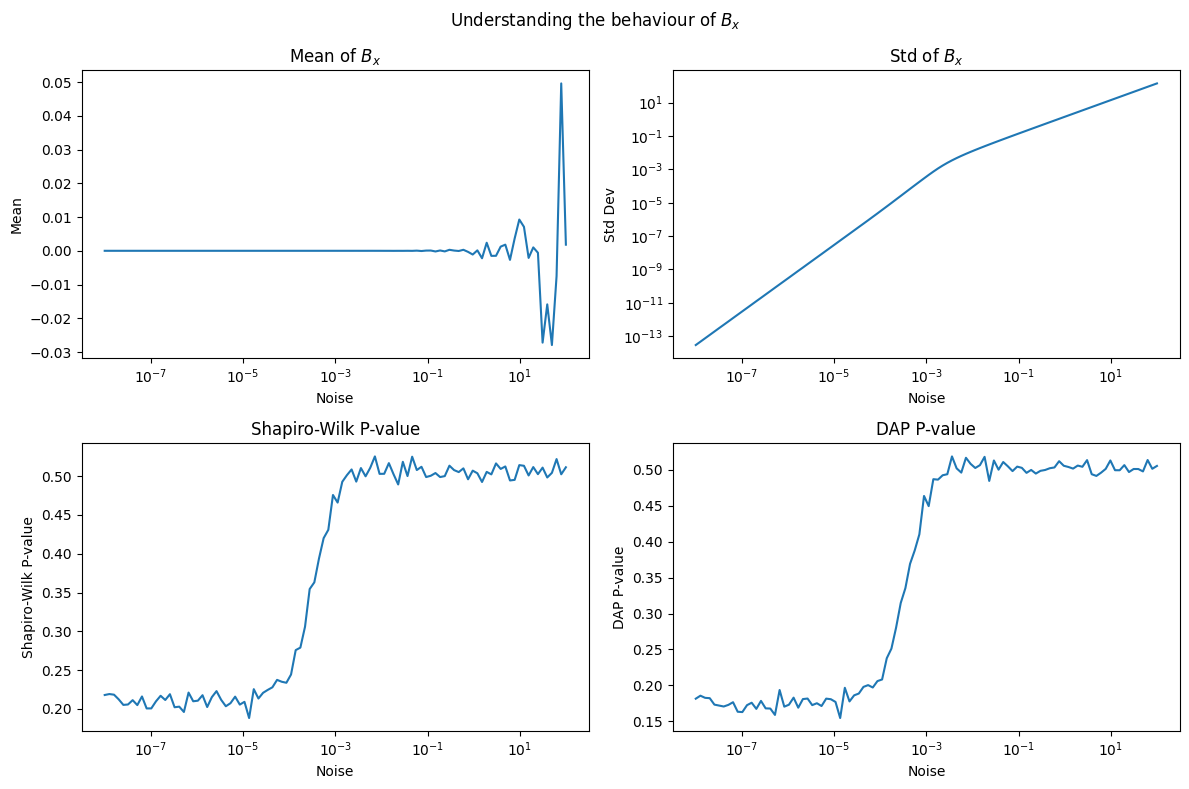

In [77]:
# Plot the results in a 2x2 grid, every parameter as a function of noise
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Understanding the behaviour of $B_x$')
axs[0, 0].plot(grouped['Noise'], grouped['Mean'])
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlabel('Noise')
axs[0, 0].set_ylabel('Mean')
axs[0, 0].set_title('Mean of $B_x$')

axs[0, 1].plot(grouped['Noise'], grouped['Std Dev'])
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Noise')
axs[0, 1].set_ylabel('Std Dev')
axs[0, 1].set_title('Std of $B_x$')

axs[1, 0].plot(grouped['Noise'], grouped['Shapiro-Wilk'])
axs[1, 0].set_xscale('log')
axs[1, 0].set_xlabel('Noise')
axs[1, 0].set_ylabel('Shapiro-Wilk P-value')
axs[1, 0].set_title('Shapiro-Wilk P-value')

axs[1, 1].plot(grouped['Noise'], grouped['DAP'])
axs[1, 1].set_xscale('log')
axs[1, 1].set_xlabel('Noise')
axs[1, 1].set_ylabel('DAP P-value')
axs[1, 1].set_title('DAP P-value')
plt.tight_layout()
plt.show()

## Distrubution
Thus, we can understand that B_x undeed has a normal distribution around 0(Since the tests yield statistically in-significant values across all noise values). 

## Standard Deviation
We can further see that for all "relevant" noise values(<0.1), we see that there is an almost-linear relationship, with some critical value around 1e-3, is this relationship worth exploring? Should we use this for some split?

## P-values
The p-values are statistically significant, but one might be interested in seeing their distribution too, since maybe some of the pixels may have most of the information.

Looking into the standard deviation of $B_x$:

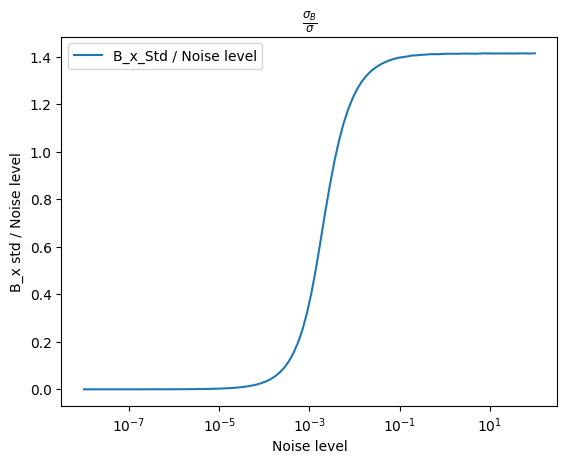

In [82]:
plt.plot(grouped['Noise'], grouped['Std Dev'] / grouped['Noise'], label='B_x_Std / Noise level')
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('B_x std / Noise level')
plt.title(r"$\frac{\sigma_B}{\sigma}$")
plt.legend()
plt.show()

We notice that the relationship between the noise levels is not linear, but is bounded by around $\sqrt2$, which could be beneficial and interestin for the bounds. 